In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torch

## 1.1.1 Transfer Learning from ImageNet

In [2]:
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

transform = transforms.Compose(
    [
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
X_train, X_val= train_test_split(
trainset, test_size=0.2, random_state=42)

trainloader = torch.utils.data.DataLoader(X_train, batch_size=64,
                                          shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(X_val, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
model_fe = models.alexnet(pretrained=True)

# We don't calculate the gradient for the actual fully-connected layer
for param in model_fe.parameters():
    param.requires_grad = False

# We get the number of input features of the fully-connected layer
num_ftrs = model_fe.classifier[6].in_features

# Adding a new fully connected linear layer
model_fe.classifier[6] = nn.Sequential (
    nn.Linear(num_ftrs, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 10),
    nn.Softmax())

In [13]:
def validate(model, modelVal, validationLoader):
    correct = 0
    total = 0
    finalLoss = 0
    batchSize = 0 
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for i, data in enumerate(validationLoader, 0):
            image, label = data
            pred = model(image)
            outputs = model(image)
            loss = criterion(outputs, label)
            finalLoss += loss       
            batchSize = i
    return finalLoss/batchSize

In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_fe.parameters(), lr=0.001)

decayRate = 0.96
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        #64, 3, 11, 11
        # forward + backward + optimize
        outputs = model_fe(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        writer.add_scalar('Model1 Loss/train', loss.item(), epoch*625+i) 
        running_loss += loss.item()
        if i % 25 == 24:    # print every 25 mini-batches
            val_loss = validate(model_fe, 1)
            print('[%d, %5d] loss: %.3f %.3f validation loss --> learning rate %.9f' %
                  (epoch + 1, i + 1, running_loss / 25, val_loss, optimizer.param_groups[0]['lr']))
            writer.add_scalar('Model1 Validation Loss/train', val_loss, epoch*625+i) 
            running_loss = 0.0
    scheduler.step()

print('Finished Training')

[1,    25] loss: 1.761 1 validation loss --> learning rate 0.001000000
[1,    50] loss: 1.776 1 validation loss --> learning rate 0.001000000


KeyboardInterrupt: 

In [12]:
model2 = models.alexnet(pretrained=True)

# We don't calculate the gradient for the actual fully-connected layer
for param in model2.parameters():
    param.requires_grad = True

# We get the number of input features of the fully-connected layer
num_ftrs = model2.classifier[6].in_features

# Adding a new fully connected linear layer
model2.classifier[6] = nn.Linear(num_ftrs, 10)

625

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

decayRate = 0.96
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        #64, 3, 11, 11
        # forward + backward + optimize
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        writer.add_scalar('Model2 Loss/train', loss.item(), epoch*625+i) 
        running_loss += loss.item()
        if i % 25 == 24:    # print every 25 mini-batches
            val_loss = validate(model2, 1)
            print('[%d, %5d] loss: %.3f %.3f validation loss --> learning rate %.9f' %
                  (epoch + 1, i + 1, running_loss / 25, val_loss, optimizer.param_groups[0]['lr']))
            writer.add_scalar('Model2 Validation Loss/train', val_loss, epoch*625+i) 
            running_loss = 0.0
    scheduler.step()

print('Finished Training')

## 1.1.2 Transfer Learning from MNIST

In [5]:
class CNN(nn.Module):
    def __init__(self,activation_function):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 3),#28x28 -> 26x26 (no pad)
            activation_function(),
            nn.MaxPool2d(2, stride = 2), #2x2 maxpool (devide hight and with by 2 -> 13x13)
            nn.Conv2d(6, 10, 3),#(no padding -> 11x11)
            activation_function(),
        )
        self.linear_lay = nn.Sequential(
            nn.Linear(1210, 300),# (11X11X10 (outchanels))
            activation_function(),
            nn.Linear(300, 50),
            activation_function(),
            nn.Linear(50,10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)# this flattens X before linear layer
        x = self.linear_lay(x) # bc this is our output layer. No activation here.
        
        return F.softmax(x, dim=1)
            

In [6]:
transform = transforms.Compose(
    [
    transforms.Grayscale(),
    transforms.ToTensor()
    ])

# SVHN
trainSVHN = torchvision.datasets.SVHN(root='./data', split='train',
                                        download=True, transform=transform)
X_trainSVHN, X_valSVHN= train_test_split(
trainSVHN, test_size=0.2, random_state=42)

trainSVHNLoader = torch.utils.data.DataLoader(X_trainSVHN, batch_size=64,
                                          shuffle=True, num_workers=2)

validationSVHNLoader = torch.utils.data.DataLoader(X_valSVHN, batch_size=64,
                                          shuffle=True, num_workers=2)

testSVHN = torchvision.datasets.SVHN(root='./data', split='test',
                                       download=True, transform=transform)

testSVHNLoader = torch.utils.data.DataLoader(testSVHN, batch_size=64,
                                         shuffle=False, num_workers=2)

# MNIST                                           
trainMNIST = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
X_trainMNIST, X_valMNIST= train_test_split(
trainMNIST, test_size=0.2, random_state=42)

trainMNISTLoader = torch.utils.data.DataLoader(X_trainMNIST, batch_size=64,
                                          shuffle=True, num_workers=2)

validationMNISTLoader = torch.utils.data.DataLoader(X_valMNIST, batch_size=64,
                                          shuffle=True, num_workers=2)

testMNIST = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testMNISTLoader = torch.utils.data.DataLoader(testMNIST, batch_size=64,
                                         shuffle=False, num_workers=2)


Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


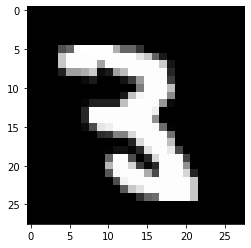

In [45]:
def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")
    plt.show()

images, labels = next(iter(trainMNISTLoader))
plot_digit(images[3])

In [14]:
import torch.optim as optim
writer = SummaryWriter()
modelMNIST = CNN(nn.LeakyReLU)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelMNIST.parameters(), lr=0.001)

decayRate = 0.96
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainMNISTLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        inputs = inputs.view(-1, 1, 28, 28)
        #64, 3, 11, 11
        # forward + backward + optimize
        outputs = modelMNIST(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        writer.add_scalar('MNIST Loss/train', loss.item(), epoch*750+i) 
        running_loss += loss.item()
            
    scheduler.step()
    val_loss = validate(modelMNIST, 3, validationMNISTLoader)
    print('[%d, %5d] loss: %.3f %.3f validation loss --> learning rate %.9f' %
          (epoch + 1, i + 1, running_loss / 750, val_loss, optimizer.param_groups[0]['lr']))
    writer.add_scalar('MNIST Validation Loss/train', val_loss, epoch) 

print('Finished Training')

[1,   750] loss: 47.656 1.511 validation loss --> learning rate 0.000960000
[2,   750] loss: 44.941 1.500 validation loss --> learning rate 0.000921600
[3,   750] loss: 44.624 1.493 validation loss --> learning rate 0.000884736
[4,   750] loss: 44.468 1.495 validation loss --> learning rate 0.000849347
[5,   750] loss: 44.359 1.487 validation loss --> learning rate 0.000815373
[6,   750] loss: 44.287 1.486 validation loss --> learning rate 0.000782758
[7,   750] loss: 44.224 1.483 validation loss --> learning rate 0.000751447


KeyboardInterrupt: 

In [ ]:
modelSVHN = modelMNIST

# We don't calculate the gradient for the actual fully-connected layer
for param in modelSVHN.parameters():
    param.requires_grad = False

# We get the number of input features of the fully-connected layer
num_ftrs = modelSVHN.classifier[6].in_features

# Adding a new fully connected linear layer
modelSVHN.classifier[6] = nn.Sequential (
    nn.Linear(num_ftrs, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 10),
    nn.Softmax())

'NVIDIA GeForce RTX 2070 Super with Max-Q Design'